<a href="https://colab.research.google.com/github/Mohamed-Devp/spam_detection_with_lstms/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this project we'll train a Spam classifier using the SMS spam collection dataset from kaggle, the goal is to use NLP & LSTMs to get a high accuracy on the test set. (you can find the dataset [here](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data))

# Data loading
we'll start by loading the necessary dependencies, downloading the dataset using the kaggle api, and loading the data into a pandas DataFrame.

## Import necessary modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from collections import Counter

import nltk
from nltk.corpus import stopwords

import random

nltk.download('stopwords')

# Use a fixed seed of reproducibility
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

## Load and read the dataset

In [ ]:
import kagglehub # kaggle api

path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")
%ls "{path}"

In [3]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv(f"{path}/spam.csv", encoding = 'latin-1')
df = df[['v1', 'v2']]
df.columns = ['Label', 'Message']

df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data cleaning
now after loading the data into a dataframe, we have to clean it by removing missing values and duplicate rows.

In [4]:
df = df.dropna().drop_duplicates().reset_index(drop = True)

print(f"Number of Missing values:\n{df.isna().sum()}",)
print(f"Number of duplicate rows:{df.duplicated().sum()}")

Number of Missing values:
Label      0
Message    0
dtype: int64
Number of duplicate rows:0


# Data exploration
in this section, we'll explore and visualize the data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5169 non-null   object
 1   Message  5169 non-null   object
dtypes: object(2)
memory usage: 80.9+ KB


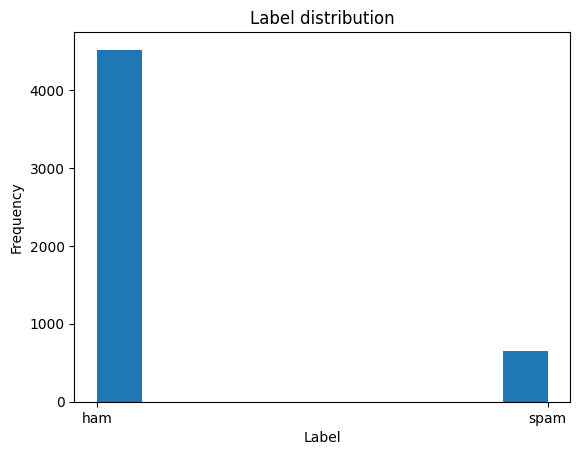

In [6]:
# Plot the label distribution
plt.hist(df['Label'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label distribution')
plt.show()

as you can see in the histogram above, the dataset is extremly imbalanced, there's way more ham (not spam) messages than spam ones.

# Data preprocessing
now after visualizing the data, we can move to the preprocessing part.
we'll tokenize and convert individual tokens into indcies to be feeded to the model.

## Tokenization

In [7]:
stop_words = set(stopwords.words('english'))

sentences = [] # tokenized messages
labels = [] # labels

max_len = 64 # maximum sentence length
for label, message in zip(df['Label'], df['Message']):

  # Remove punctuation and special characters
  message = re.sub(r"[^\w\s]", " ", message.lower())
  tokenized = message.split()

  # Filter stop words
  tokenized = [token for token in tokenized if token not in stop_words]
  tokenized = tokenized if len(tokenized) <= max_len else tokenized[:max_len]

  if len(tokenized) == 0:
    continue

  sentences.append(tokenized)
  labels.append(1 if label == 'spam' else 0)

lengths = [len(sentence) for sentence in sentences] # Length of each sequence

## Convert tokens into indices

In [8]:
tokens = [token for sentence in sentences for token in sentence]
counts = Counter(tokens)

max_words = 7000
token_to_index = {token: index for index, (token, _) in enumerate(counts.most_common(max_words - 2), start = 2)}

# Include special tokens
token_to_index['<PAD>'] = 0
token_to_index['<OOV>'] = 1

inputs = np.zeros((len(sentences), max_len), dtype = np.int32)

for i, sentence in enumerate(sentences):
  # Replace OOVs
  sentence = [token if token in token_to_index else '<OOV>' for token in sentence]

  # Pad the sequence into a fixed length
  if len(sentence) < max_len:
    sentence += ['<PAD>'] * (max_len - len(sentence))

  # Convert into indices
  inputs[i] = np.array([token_to_index[token] for token in sentence])

# Convert into tensors
inputs = torch.tensor(inputs, dtype = torch.int32)
targets = torch.tensor(labels, dtype = torch.float32)

lengths = torch.tensor(lengths, dtype = torch.int32)

## Split the data

In [9]:
def split(tensor, perc = .8):
  idx = int(len(tensor) * perc)
  return tensor[:idx], tensor[idx:]

X_train, X_test = split(inputs)
y_train, y_test = split(targets)

X_valid, X_test = split(X_test, perc = .5)
y_valid, y_test = split(y_test, perc = .5)

train_lengths, test_lengths = split(lengths)
valid_lengths, test_lengths = split(test_lengths, perc = .5)

# Building and Training the classifier

## Define the model architecture
the model is structured as follow:


*   **Embedding layer**: map each input token to an embedding vector.

*   **LSTM**: processes the embedded token sequences.

*   **Output layer**: a dense layer that maps the lstm output into a logit which then passed to the sigmoid activation function.





In [30]:
# Define the model architecture
class SpamDetector(nn.Module):
  def __init__(
      self,
      vocab_size,
      embedding_dim,
      hidden_size,
  ):
    super(SpamDetector, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
    self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first = True)
    self.output = nn.Linear(hidden_size, 1)

  def configure(self, criterion, optimizer):
    self.criterion = criterion
    self.optimizer = optimizer

  def forward(self, inputs, lengths, probs = False):
    embedded = self.embedding(inputs)

    # pack the padded embedding sequences before feeding into the LSTM
    packed = pack_padded_sequence(
        embedded,
        lengths,
        batch_first=True,
        enforce_sorted=False
    )

    lstm_out, (h_n, c_n) = self.lstm(packed)
    output = self.output(h_n[-1]).squeeze()

    if not probs:
      return output

    return F.sigmoid(output)

  def backward(self, inputs, targets, lengths):
    self.optimizer.zero_grad()

    outputs = self.forward(inputs, lengths)
    loss = self.criterion(outputs, targets)

    loss.backward()
    self.optimizer.step()

    return loss.item()

# Build the model
model = SpamDetector(
    vocab_size = len(token_to_index),
    embedding_dim = 32,
    hidden_size = 64
)

optimizer = optim.SGD(model.parameters(), .01)
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(6.0)) # weights the positive samples loss to reduce the effect of class imbalance

model.configure(criterion, optimizer)

losses = {
    'training': [],
    'validation': []
}

## Train the model

In [31]:
def has_stabilized(losses, window_size = 100, threshold = .0001):
  """Returns True if losses has stabilized, False otherwise."""
  if len(losses) < window_size:
    return False

  window = losses[-(window_size + 1):]
  diffs = np.diff(window)
  mean_diff = np.mean(diffs)

  return mean_diff < threshold

In [ ]:
# Fit the model to the data
batch_size = 64
num_epochs = 150

for epoch in range(num_epochs):
  epoch_loss = num_batchs = 0

  # Shuffle the data before each epoch
  shuffled = torch.randperm(len(X_train))

  for start in range(0, len(X_train), batch_size):
    end = min(start + batch_size, len(X_train))

    X_batch = X_train[shuffled][start:end]
    y_batch = y_train[shuffled][start:end]
    lengths_batch = train_lengths[shuffled][start:end]

    loss = model.backward(X_batch, y_batch, lengths_batch)
    epoch_loss += loss
    num_batchs += 1

  # Compute the validation loss
  outputs = model.forward(X_valid, valid_lengths)
  valid_loss = model.criterion(outputs, y_valid)

  losses['training'].append(epoch_loss / num_batchs)
  losses['validation'].append(valid_loss.item())

  # Apply early stopping to reduce overfiting
  if has_stabilized(losses['validation']):
    break

  if epoch == 0 or (epoch + 1) % 10 == 0:
    print(f"Epoch: {epoch + 1} - Loss: {losses['validation'][-1]:.2f}")

In [39]:
# Save the model
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'vocab': token_to_index
}, 'spamdetecor_state.pth')

## Evaluate the model
evaluate the model on the testing test to make sure we got the best results. i used the accuracy, recall and precision which is enough to tell wether the model did a good job.

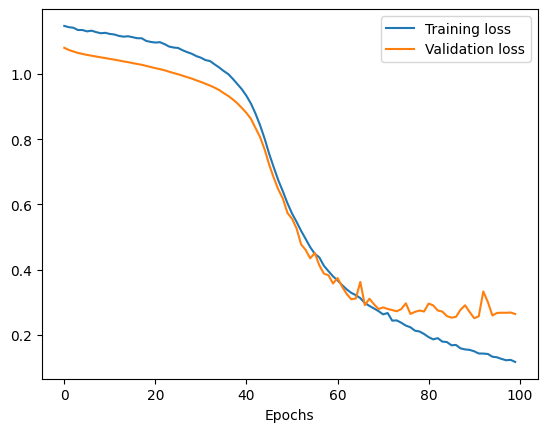

In [38]:
# Plot the loss curve
plt.plot(losses['training'], label = 'Training loss')
plt.plot(losses['validation'], label = 'Validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [40]:
class Evaluation:
  def __init__(self, model, metrics):
    """Initializes the Evaluation class, which ehandles valuating model
    on different sets and metrics"""

    self.model = model
    self.metrics = metrics

  def run(
      self,
      name,
      inputs, targets,
      lengths,
      threshold = .5
  ):
    probs = model.forward(inputs, lengths, probs = True)
    preds = (probs >= threshold).type(torch.int32)

    print(f"{name} results:")
    for metric, func in self.metrics:
      print(f"{metric} score: {func(targets, preds):.2f}")

    print()

def accuracy(targets, preds):
  return torch.sum(targets == preds) / targets.shape[0]

def recall(targets, preds):
  true_pos = torch.sum((targets == 1) & (preds == 1))
  actual_pos = torch.sum(targets == 1)

  if actual_pos == 0:
    return 0.00

  return true_pos / actual_pos

def precision(targets, preds):
  true_pos = torch.sum((targets == 1) & (preds == 1))
  classified_pos = torch.sum(preds == 1)

  if classified_pos == 0:
    return 0.00

  return true_pos / classified_pos

In [41]:
eval = Evaluation(
    model,
    metrics = [('Accuracy', accuracy),('Recall', recall), ('Presicion', precision)]
)

eval.run('Train', X_train, y_train, train_lengths, threshold=.5)
eval.run('Test', X_test, y_test, test_lengths, threshold=.5)

Train results:
Accuracy score: 0.99
Recall score: 0.98
Presicion score: 0.94

Test results:
Accuracy score: 0.98
Recall score: 0.93
Presicion score: 0.89



# Try the model on real word examples

In [54]:
def detect(model, message):
  """Uses the pretrained model to check if message is a spam."""
  # Preprocess the given message
  test = re.sub(r"[^\w\s]", " ", message.lower())
  tokenized = test.split()

  tokenized = [token for token in tokenized if token not in stop_words]
  tokenized = [token if token in token_to_index else '<OOV>' for token in tokenized]
  length = len(tokenized)

  if length > max_len:
    tokenized = tokenized[:max_len]
    length = max_len
  else:
    tokenized += ['<PAD>'] * (max_len - len(tokenized))

  input_seq = torch.tensor([[token_to_index[token] for token in tokenized]])
  lengths = torch.tensor([length], dtype = torch.int32)

  prob = model.forward(input_seq, lengths, probs = True)
  if prob < .5:
    print(f"The model is {(1 - prob) * 100:.1f}% confident that '{message}' is not a spam.")
  else:
    print(f"The model is {prob * 100:.1f}% confident that '{message}' is a spam.")

In [55]:
detect(
    model,
    "Congratulations! You've won a $1,000 Walmart gift card. Click here to claim now: http://bit.ly/winbig123"
)

The model is 65.5% confident that 'Congratulations! You've won a $1,000 Walmart gift card. Click here to claim now: http://bit.ly/winbig123' is a spam.


In [56]:
detect(
    model,
    "Dear user, we noticed unusual activity on your account. Please verify your identity immediately to avoid suspension: https://secure-login-alert.com"
)

The model is 98.7% confident that 'Dear user, we noticed unusual activity on your account. Please verify your identity immediately to avoid suspension: https://secure-login-alert.com' is a spam.


In [57]:
detect(
    model,
    "Hi John, just checking in on the invoice from last week. Can you confirm the payment was sent? Here’s the link again just in case: drive.google.com/folder/invoice2025"
)

The model is 92.0% confident that 'Hi John, just checking in on the invoice from last week. Can you confirm the payment was sent? Here’s the link again just in case: drive.google.com/folder/invoice2025' is not a spam.
